<font size=3><strong>Intro</strong></font><br />
This article aims to guide you through the process of conducting a back-test for a strategy based on technical indicators using Python. In this case, we will focus on implementing a Simple Moving Average (SMA)-based strategy to generate trading signals and positions.

<font size=3><strong> SMA Strategy Strategy</strong></font><br />

In this SMA-based strategy, we'll follow these key steps:

Calculate the SMA with a 9 and 26-day window to identify trends in the price data.
Generate long signals when the closing price crosses above the SMA, indicating a potential uptrend.
Generate short signals when the closing price crosses below the SMA, signaling a potential downtrend.
Maintain positions based on these signals.
Calculate strategy returns and assess performance.
The SMA strategy allows us to take advantage of trends in the market by analyzing the moving average of the closing prices over a specified time period.

<font size=3><strong>Here are the steps to create your own back-testing code.</strong></font> <br />

Import the necessary libraries.
Retrieve OHLCV data.
Compute daily returns.
Establish data columns tailored to the strategy.
Develop strategy indicators.
Generate trading signals and positions.
Evaluate the outcomes.
By following these steps, you can implement and back-test an SMA-based trading strategy using Python, gaining valuable insights into its performance and potential profitability.

<font size=3><strong>Step 1 : Import necessary libraries</strong></font>

In [112]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf
import warnings
warnings.filterwarnings('ignore')  # Ignore printing all warnings

# print all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<font size=3><strong>Step 2 : Download OHLCV: (Open, High, Low, Close, Volume) data</strong></font></br>
I utilize the Yahoo Finance Python API, known as yfinance, to access the necessary data. It's worth noting that there are numerous open and free resources available for obtaining historical data, which is crucial for effectively backtesting your trading strategies.

In [113]:
# downloading historical necessary data for backtesting and analysis
start_date ='2015-01-01'
end_date = '2020-12-31'
ticker = 'SBIN.NS'
df = yf.download(tickers=ticker, start = start_date, end = end_date) 

[*********************100%%**********************]  1 of 1 completed


<font size=3><strong>Step 3 : Calculate daily returns</strong></font></br>
In this step, we calculate daily returns to assess the performance in comparison to a buy and hold strategy, which serves as the benchmark. Essentially, this step aims to determine whether the strategy outperforms the straightforward approach of purchasing and holding the stock. A successful strategy should ideally yield superior results compared to a buy-and-hold strategy.

In [114]:
# calculating buy and hold strategy returns
df['buy_and_hold_returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,buy_and_hold_returns
Date,,,,,,,
2015-01-01,312.450012,315.000000,310.700012,314.00,290.288177,6138488,NaN
2015-01-02,314.350006,318.299988,314.350006,315.25,291.443787,9935094,0.003973
2015-01-05,316.250000,316.799988,312.100006,312.75,289.132568,9136716,-0.007962


<font size=3><strong>Step 4 : Create strategy-based data columns</strong></font></br>
The subsequent phase involves developing indicators that establish the criteria for the strategy. In the case of the Simple Moving Average Based strategy, this entails working with the 9 and 26-day moving average, and controling moving average of avearge moving period. These indicators are denoted as [slow_SMA,fast_SMA and control_SMA].


In [115]:
# ATR and SMA indicators
slow_window=9
fast_window=26

#Entry and Exit SMA
control_window = int((fast_window +slow_window)/2)

#ATR 
high_low = df['High'] - df['Low']
high_close = abs(df['High'] - df['Close'].shift(1))
low_close = abs(df['Low'] - df['Close'].shift(1))

tr = pd.DataFrame({'high_low': high_low, 'high_close': high_close, 'low_close': low_close})
true_range = tr.max(axis=1)

# ATR calculation using a 14-day period (you can adjust the period as needed)
atr_period = 14
atr = true_range.rolling(window=atr_period).mean()

# Assign the calculated ATR values to a new column in your DataFrame
df['ATR'] = atr

#SMA

df['slow_SMA'] = df['Adj Close'].rolling(window=slow_window).mean()
df['fast_SMA'] = df['Adj Close'].rolling(window=fast_window).mean()
df['control_SMA'] = df['Adj Close'].rolling(window=control_window).mean()


df.drop(['Open','High','Low','Close'],axis=1,inplace=True,errors='ignore')
df.tail(5)

,Adj Close,Volume,buy_and_hold_returns,ATR,slow_SMA,fast_SMA,control_SMA
Date,,,,,,,
2020-12-23,251.698547,29056404,0.021328,8.007145,255.314000,246.145944,253.173502
2020-12-24,255.383118,28585509,0.014533,7.653574,254.718518,247.126899,254.231864
2020-12-28,263.374298,36870242,0.030811,7.703573,254.824851,247.980863,255.822221
2020-12-29,265.958282,45032526,0.009763,7.471428,255.595793,249.385118,257.038212
2020-12-30,265.001221,30971894,-0.003605,7.507144,256.393312,250.642138,257.792573


<Axes: xlabel='Date'>

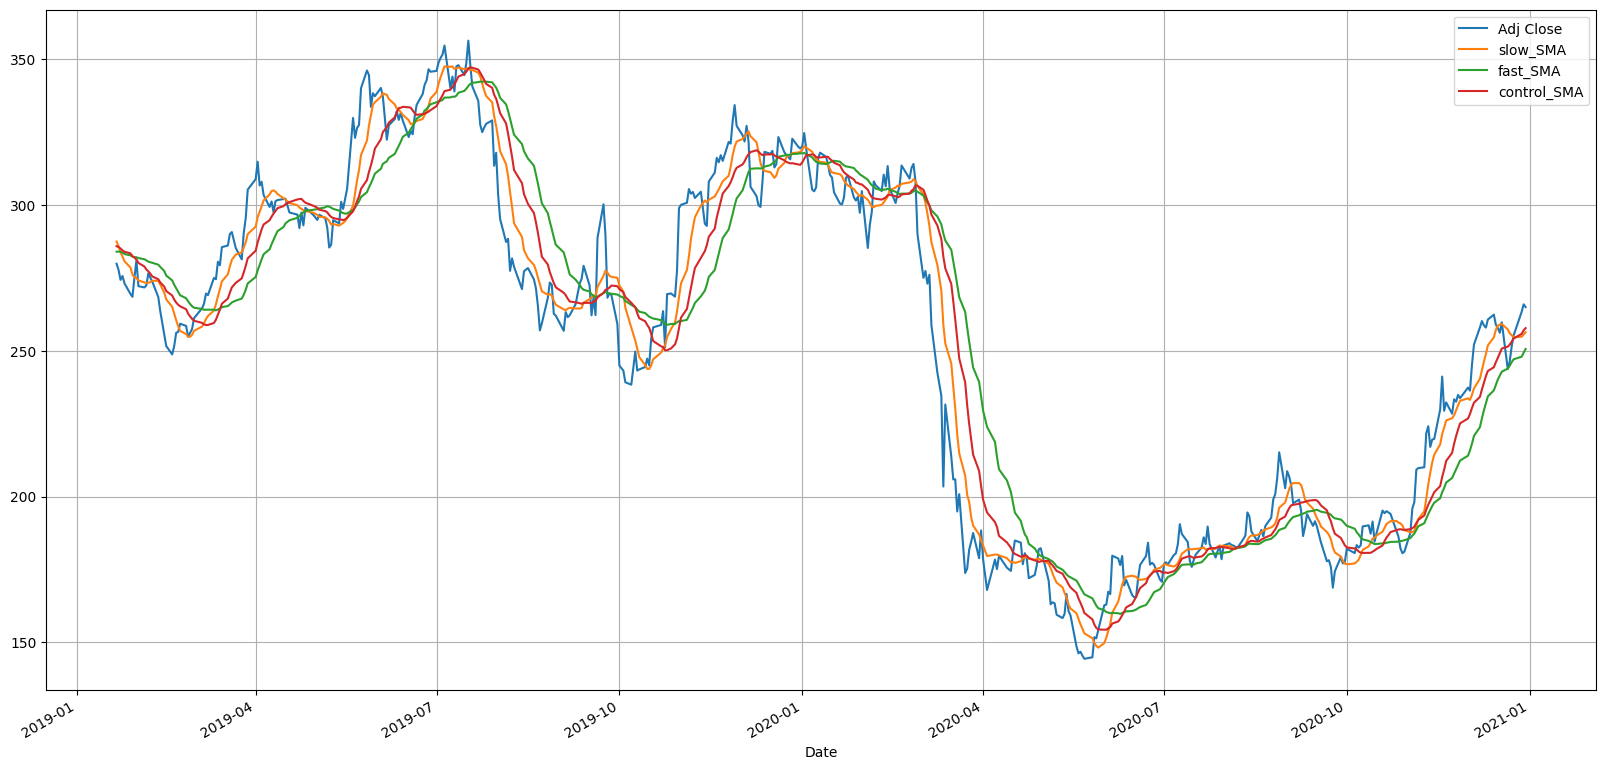

In [116]:
df[['Adj Close','slow_SMA','fast_SMA','control_SMA']][1000:2000].plot(figsize=(20,10),grid=True)

<font size=3><strong>Step 5 : Create strategy indicators</strong></font></br>
The subsequent stage represents the pivotal aspect of formulating the strategy. It encompasses the following key components:

Here are the key steps:

- Generate long signals when the fast_SMA crosses above the slow_SMA and control_SMA 
- Generate short signals when the slow_SMA  crosses below the fast_SMA and the control_SMA 
- Maintain positions based on these signals.

In [117]:
# Long condition
df['signal'] = np.where( (df['slow_SMA'] < df['fast_SMA']) & 
                        (df['slow_SMA'].shift(1) >= df['fast_SMA']) &
                        (df['fast_SMA'] > df['control_SMA']),1,0)

# Short condition
df['signal'] = np.where( (df['slow_SMA'] > df['fast_SMA']) & 
                        (df['slow_SMA'].shift(1) <= df['fast_SMA']) &
                        (df['fast_SMA'] < df['control_SMA']),-1,df['signal'])


# creating long and short positions 
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)
df.dropna(inplace=True)

# calculating stretegy returns
df['strategy_returns'] = df['buy_and_hold_returns'] * (df['position'])
df.dropna(inplace=True)
df.tail(50)

,Adj Close,Volume,buy_and_hold_returns,ATR,slow_SMA,fast_SMA,control_SMA,signal,position,strategy_returns
Date,,,,,,,,,,
2020-10-20,194.324692,39316753,-0.004668,6.264285,189.289647,183.985092,184.726247,0,-1.0,0.004668
2020-10-21,194.994598,54515523,0.003441,6.553570,190.592268,184.178338,185.939422,0,-1.0,-0.003441
2020-10-22,194.563934,33721637,-0.002211,6.389284,191.123949,184.294286,186.842969,0,-1.0,0.002211
2020-10-23,194.085419,32707020,-0.002462,6.196427,191.559930,184.463606,187.842220,0,-1.0,0.002462
2020-10-26,188.247543,45470123,-0.030541,6.524998,191.666267,184.509617,188.478361,0,-1.0,0.030541
2020-10-27,186.285629,37794381,-0.010477,6.614285,191.092048,184.585074,188.723248,0,-1.0,0.010477
2020-10-28,182.266129,46458319,-0.021813,6.664285,190.836841,184.756235,188.818951,0,-1.0,0.021813
2020-10-29,180.591324,44822673,-0.009231,6.417856,190.065903,184.848257,188.655693,0,-1.0,0.009231
2020-10-30,181.117676,41519686,0.002910,6.214286,188.497438,185.048865,188.574063,0,-1.0,-0.002910


In [118]:
df['signal'].value_counts()

 0    1438
-1      11
 1       5
Name: signal, dtype: int64

<font size=3><strong>Step 6 : Create signals and positions</strong></font></br>
The subsequent step entails comparing the strategy's performance by calculating cumulative returns. This process involves multiplying the positions with the daily returns on an element-wise basis.

Buy and hold returns: -0.014382415140334911
Strategy returns: 0.8871138156493471


<Axes: xlabel='Date'>

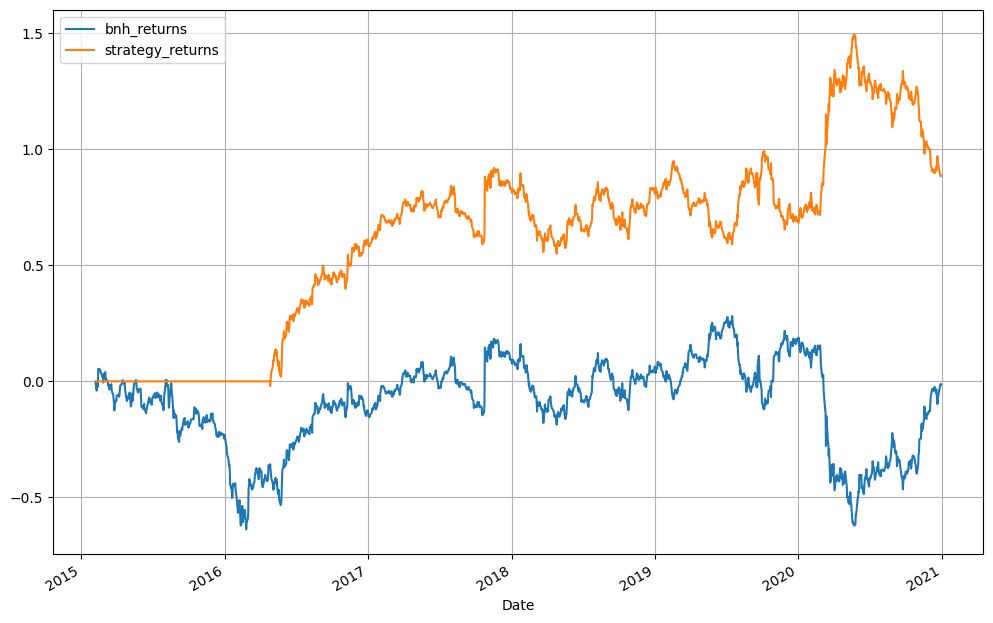

In [119]:
# comparing buy & hold strategy / bollinger bands strategy returns
print("Buy and hold returns:",df['buy_and_hold_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['buy_and_hold_returns','strategy_returns']].cumsum()
df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

<font size=3><strong>Step 7 : Analyze results</strong></font></br>

In this stage, I employ Pyfolio, a Python library designed for the assessment of performance and risk in financial portfolios.






Start date,2015-02-06
End date,2020-12-30
Total months,69
,Backtest
Annual return,10.5%
Cumulative returns,77.9%
Annual volatility,33.2%
Sharpe ratio,0.46
Calmar ratio,0.22
Stability,0.67
Max drawdown,-48.2%


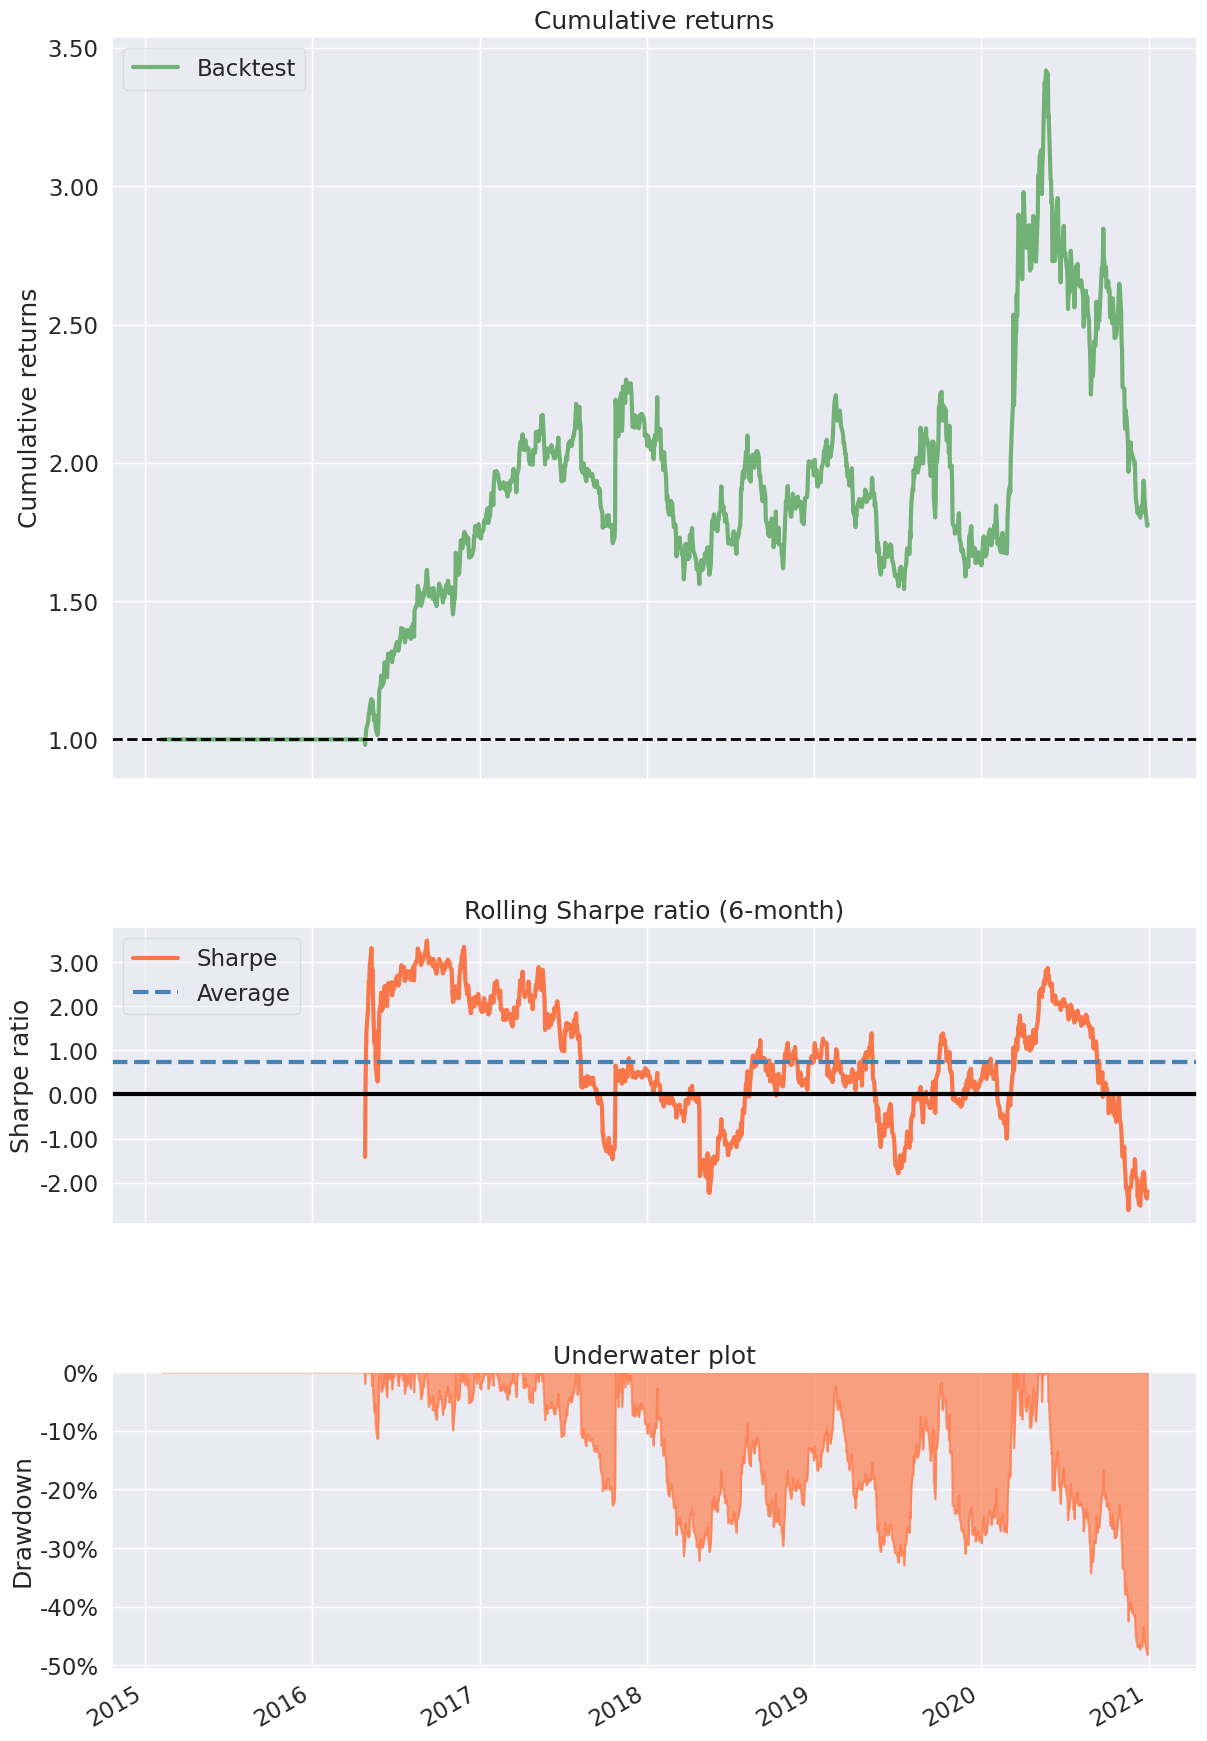

In [120]:
pf.create_simple_tear_sheet(df['strategy_returns'].diff())

<font size=3><strong>Comments</strong></font></br>
The results obtained through pyfolio provide a clear and comprehensible overview of the findings.

In the analysis of historical data, it was evident that the 'SMA CrossOver' strategy did  outperform the straightforward buy and hold approach.

However, it is essential to exercise caution when considering the transition from back-testing to live implementation, even if the former suggests promising returns. Several factors, such as transaction costs and stock price momentum, can introduce unforeseen risks into the equation.

To enhance a strategy's performance, one can explore optimization opportunities by assessing the returns associated with various strategy parameters. Additionally, the incorporation of different technical indicators in combination can generate more reliable signals, ultimately mitigating risks and enhancing overall performance.

For live strategies, it is advisable to implement safeguards like stop-loss mechanisms and kill switches to maintain control in case the strategy deviates from its intended course. These precautions are vital for safeguarding investments and minimizing potential losses.